# DATA:https://www.kaggle.com/mdsafayet/multiclass-disease-classification

## Importing Libaries

In [2]:
import os
import csv
import shutil
import time

import random
from sklearn.metrics import confusion_matrix 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, metrics
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

## Display a sample image in 42x42

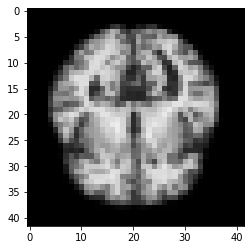

In [3]:
imageOne = cv2.imread("C:/Users/Fatih/Downloads/alzheimer data/Alzheimer MildDemented/mildDem48.jpg")
imageOne = cv2.resize(imageOne, (42, 42), interpolation = cv2.INTER_AREA)
imageOne = np.array(imageOne)
imageOne = imageOne.astype("float32")
imageOne /= 255
plt.imshow(imageOne)

## Functions

In [4]:
def preparingImages(dataPath, labels, newTrainPath, newTestPath, newValidationPath, validationSplit, testSplit): 
    # this function for creating validation Image set and also creating new test Image set
    trainingFrequencies = []
    for label in labels:
        trainingFileNames = os.listdir(dataPath+"Alzheimer "+label +"/")
        validationFileNames = random.sample(trainingFileNames,int(len(trainingFileNames)*validationSplit))
        trainingFileNamesBeforeTestSplit = [file for file in trainingFileNames if file not in validationFileNames]
        testFileNames = random.sample(trainingFileNamesBeforeTestSplit,int(len(trainingFileNamesBeforeTestSplit)*((1+validationSplit) * testSplit)))
        newTrainingFileNames = [file for file in trainingFileNamesBeforeTestSplit if file not in testFileNames]
        for file in newTrainingFileNames:
            shutil.copy(dataPath + "Alzheimer " + label + "/" + file, newTrainPath + label + "/" + file)
        print("Train images transfer complate for label: " + label + "number of transferred images = " + str(len(newTrainingFileNames)))
        for file in validationFileNames:
            shutil.copy(dataPath + "Alzheimer " + label + "/" + file, newValidationPath + label + "/" + file)
        print("Train images transfer complate for label: " + label + "number of transferred images = " + str(len(validationFileNames)))
        for file in testFileNames:
            shutil.copy(dataPath + "Alzheimer " + label + "/" + file, newTestPath + label + "/" + file)
        print("Train images transfer complate for label: " + label + "number of transferred images = " + str(len(testFileNames)))
        print("Frequency of " + label + ": " + str(len(newTrainingFileNames)))
        trainingFrequencies.append(len(newTrainingFileNames))
    return trainingFrequencies

In [5]:
def createDictionaries(path, labels, datasetTypes = ["train","test","validation"]):
    if path[-1] != "/":
        path = path + "/"
    for dataset in datasetTypes:
        datasetPath = os.path.join(path,dataset)
        os.mkdir(datasetPath)
        for label in labels:
            labelPath = os.path.join(datasetPath,label)
            os.mkdir(labelPath)
            print(f"Dictionary {labelPath} created")

In [6]:
def copyImagesUntillSameNumberOfImage(trainingFrequencies, labels, TrainPath):
    #this function provides increasae number of samples at each labels to maximum number of trainingFrequencies
    trainLabelFrequenciesArr = np.array(trainingFrequencies)
    targetSample = np.max(trainLabelFrequenciesArr)
    for i in range(4):
        imageCounter = 0
        currentLabel = labels[i]
        missingSamples = targetSample - trainLabelFrequenciesArr[i]
        filenames = os.listdir(TrainPath+currentLabel+"/")
        numberOfFilled = np.zeros(len(filenames))
        while np.sum(numberOfFilled) < missingSamples:
            index = np.random.randint(0,len(filenames))
            shutil.copy(TrainPath+currentLabel+"/"+filenames[index],
                        TrainPath+currentLabel+"/"+filenames[index].replace(".jpg","_copy_"+str(int(numberOfFilled[index]+1))+".jpg"))
            numberOfFilled[index] += 1
            imageCounter += 1
        print(f"{imageCounter} Images copied to: {TrainPath+currentLabel+'/'}")

In [16]:
def testModel(model, testData, saveGraph = False, matrixRoundSize = 3, timeRoundSize = 3, labels):
    predictions= []
    realValues= []
    i = 0
    timeBeforePrediction = time.time()
    for batch, label in testData:
        prediction = model.predict(batch).argmax(axis = -1)
        predictions.extend(prediction)
        realValues.extend(label.argmax(axis = -1))
        i += 1
        if i > len(testData.labels):
            break
    timeAfterPrediction = time.time()
    totalTime = round((timeAfterPrediction - timeBeforePrediction), timeRoundSize)
    averageTime = round((timeAfterPrediction - timeBeforePrediction) / len(testData.labels), timeRoundSize)
    print(f"{len(testData.labels)} image(s) predicted at {totalTime} sec")
    print(f"Average predict time equals to =  {averageTime} sec")
    confusionMatrix = confusion_matrix(realValues, predictions)
    relativeConfusionMatrix = confusionMatrix / np.sum(confusionMatrix, axis = 0)
    figure, axis = plt.subplots(1,2,figsize=(20,20))
    image1 = axis[0].imshow(confusionMatrix, cmap = plt.get_cmap("GnBu"))
    image2 = axis[1].imshow(confusionMatrix, cmap = plt.get_cmap("GnBu"))
    for (i, j), k in np.ndenumerate(confusionMatrix):
        axis[0].text(j, i, s = str(k), ha = "center", va = "center")
        axis[0].set_xticks(np.arange(0,len(labels), 1))
        axis[0].set_xticklabels(labels)
        axis[0].set_yticks(np.arange(0,len(labels), 1))
        axis[0].set_yticklabels(labels)
        axis[0].set_title("Confusion Matrix")
    for (i, j), k in np.ndenumerate(relativeConfusionMatrix):
        axis[1].text(j, i, s = str(np.round(k, matrixRoundSize)), ha = "center", va = "center")
        axis[1].set_xticks(np.arange(0,len(labels), 1))
        axis[1].set_xticklabels(labels)
        axis[1].set_yticks(np.arange(0,len(labels), 1))
        axis[1].set_yticklabels(labels)
        plt.subplots_adjust(wspace = 0.5)
        axis[1].set_title("Confusion Matrix")
    while saveGraph:
        path = input(r"Enter path where you want to save the figure:")
        try:
            if path[-1] != "/":
                path = path + "/"
            print(path)
            figure.savefig(path + "ConfusionMatrix and relativeConfusionMatrix of model.png")
            saveGraph = False
        except:
            print("Saving figure could not complete do you want to try again ?")
            isContinue = input("1 : Yes | any text except '1' : No")
            if isContinue != "1":
                saveGraph = False
    return confusion_matrix(realValues, predictions)

SyntaxError: non-default argument follows default argument (Temp/ipykernel_5656/12159153.py, line 1)

## Creating Datasets 

In [10]:
dataPath = "C:/Users/Fatih/Downloads/alzheimer data/"
newDataPath = "C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/"
validationSplit = 1/6
testSplit = 1/6
newTrainPath = newDataPath + "train/"
newTestPath = newDataPath + "test/"
newValidationPath = newDataPath + "validation/"
labels = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

In [8]:
createDictionaries(newDataPath, labels)

Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train\NonDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train\VeryMildDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train\MildDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train\ModerateDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/test\NonDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/test\VeryMildDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/test\MildDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/test\ModerateDemented created
Dictionary C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer 

In [9]:
trainingFrequencies = preparingImages(dataPath, labels, newTrainPath, newTestPath, newValidationPath, validationSplit, testSplit)

Train images transfer complate for label: NonDementednumber of transferred images = 2149
Train images transfer complate for label: NonDementednumber of transferred images = 533
Train images transfer complate for label: NonDementednumber of transferred images = 518
Frequency of NonDemented: 2149
Train images transfer complate for label: VeryMildDementednumber of transferred images = 1504
Train images transfer complate for label: VeryMildDementednumber of transferred images = 373
Train images transfer complate for label: VeryMildDementednumber of transferred images = 363
Frequency of VeryMildDemented: 1504
Train images transfer complate for label: MildDementednumber of transferred images = 602
Train images transfer complate for label: MildDementednumber of transferred images = 149
Train images transfer complate for label: MildDementednumber of transferred images = 145
Frequency of MildDemented: 602
Train images transfer complate for label: ModerateDementednumber of transferred images = 4

In [10]:
copyImagesUntillSameNumberOfImage(trainingFrequencies, labels, newTrainPath)

0 Images copied to: C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train/NonDemented/
645 Images copied to: C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train/VeryMildDemented/
1547 Images copied to: C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train/MildDemented/
2105 Images copied to: C:/Users/Fatih/Desktop/python/machine learning/alzheimer/alzheimer data/new/train/ModerateDemented/


In [8]:
trainDataGenerator = ImageDataGenerator(rescale=1./255,
                                       rotation_range=0.1,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       brightness_range=[0.8,1.2],
                                       zoom_range=0.1,
                                       horizontal_flip=False,
                                       fill_mode="nearest")
testDataGenerator = ImageDataGenerator(rescale=1./255)
validationDataGenerator = ImageDataGenerator(rescale=1./255)

In [11]:
trainData = trainDataGenerator.flow_from_directory(newTrainPath, (176,208), batch_size=100, class_mode="categorical")
testData = testDataGenerator.flow_from_directory(newTestPath, (176,208), batch_size=1, class_mode="categorical")
validationData = validationDataGenerator.flow_from_directory(newValidationPath, (176,208), batch_size=100, class_mode="categorical")

Found 8596 images belonging to 4 classes.
Found 1036 images belonging to 4 classes.
Found 1065 images belonging to 4 classes.


## Creating Model 

In [13]:
model = Sequential() 

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(176,208,3)))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())

model.add(Dense(128, activation='relu'))


model.add(Dense(4, activation='softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = optimizers.Adam(lr=0.001, beta_1= 0.9, beta_2=0.999, epsilon=1e-8, decay=0.0),
             metrics = metrics.CategoricalAccuracy(name="categorical_accuracy"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 174, 206, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 103, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 101, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 22, 128)       1

In [14]:
earlyStopping = EarlyStopping(mode="min",verbose=1,patience=50)
checkpointer = ModelCheckpoint(filepath="C:/Users/Fatih/Desktop/python/machine learning/alzheimer/" + 'alzheimerModel176x208.h5', verbose=1, save_best_only=True)

epochs = 250
batchSize = 100

hist = model.fit(trainData,
                 epochs=epochs,
                 batch_size=batchSize,
                 validation_data = validationData,
                 callbacks=[earlyStopping,checkpointer], verbose=2)

model_json = model.to_json()
with open("C:/Users/Fatih/Desktop/python/machine learning/alzheimer/" + 'alzheimerModel176x208.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/250

Epoch 00001: val_loss improved from inf to 1.24973, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 195s - loss: 1.3848 - categorical_accuracy: 0.2691 - val_loss: 1.2497 - val_categorical_accuracy: 0.3493
Epoch 2/250

Epoch 00002: val_loss improved from 1.24973 to 0.95016, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 188s - loss: 1.1120 - categorical_accuracy: 0.4994 - val_loss: 0.9502 - val_categorical_accuracy: 0.5324
Epoch 3/250

Epoch 00003: val_loss improved from 0.95016 to 0.92864, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 188s - loss: 0.8104 - categorical_accuracy: 0.6297 - val_loss: 0.9286 - val_categorical_accuracy: 0.5587
Epoch 4/250

Epoch 00004: val_loss did not improve from 0.92864
86/86 - 188s - loss: 0.7101 - categorical_accuracy: 0.6704 - val_loss: 1.1124 - val_categorical_accu

Epoch 37/250

Epoch 00037: val_loss did not improve from 0.16896
86/86 - 187s - loss: 0.1338 - categorical_accuracy: 0.9482 - val_loss: 0.2247 - val_categorical_accuracy: 0.9164
Epoch 38/250

Epoch 00038: val_loss did not improve from 0.16896
86/86 - 187s - loss: 0.1378 - categorical_accuracy: 0.9477 - val_loss: 0.2674 - val_categorical_accuracy: 0.8930
Epoch 39/250

Epoch 00039: val_loss did not improve from 0.16896
86/86 - 187s - loss: 0.1395 - categorical_accuracy: 0.9450 - val_loss: 0.2554 - val_categorical_accuracy: 0.9033
Epoch 40/250

Epoch 00040: val_loss did not improve from 0.16896
86/86 - 188s - loss: 0.1225 - categorical_accuracy: 0.9542 - val_loss: 0.2301 - val_categorical_accuracy: 0.9183
Epoch 41/250

Epoch 00041: val_loss did not improve from 0.16896
86/86 - 188s - loss: 0.1094 - categorical_accuracy: 0.9589 - val_loss: 0.3011 - val_categorical_accuracy: 0.8854
Epoch 42/250

Epoch 00042: val_loss did not improve from 0.16896
86/86 - 188s - loss: 0.1180 - categorical_acc

Epoch 81/250

Epoch 00081: val_loss improved from 0.13262 to 0.11557, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 187s - loss: 0.0447 - categorical_accuracy: 0.9819 - val_loss: 0.1156 - val_categorical_accuracy: 0.9681
Epoch 82/250


KeyboardInterrupt: 

I stop train manually

In [17]:
os.chdir("C:/Users/Fatih/Desktop/python/machine learning/alzheimer/")
lastCheckpoint = tf.keras.models.load_model("alzheimerModel176x208.h5")
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

In [21]:
#I train model again for increasing accuracy
earlyStopping = EarlyStopping(mode="min",verbose=1,patience=10)
checkpointer = ModelCheckpoint(filepath="C:/Users/Fatih/Desktop/python/machine learning/alzheimer/" + 'alzheimerModel176x208.h5', verbose=1, save_best_only=True)

epochs = 75
batchSize = 100

hist = lastCheckpoint.fit(trainData,
                 epochs=epochs,
                 batch_size=batchSize,
                 validation_data = validationData,
                 callbacks=[earlyStopping,checkpointer], verbose=2)

model_json = model.to_json()
with open("C:/Users/Fatih/Desktop/python/machine learning/alzheimer/" + 'alzheimerModel176x208.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/75

Epoch 00001: val_loss improved from inf to 0.15746, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 184s - loss: 0.0512 - categorical_accuracy: 0.9826 - val_loss: 0.1575 - val_categorical_accuracy: 0.9559
Epoch 2/75

Epoch 00002: val_loss did not improve from 0.15746
86/86 - 206s - loss: 0.0437 - categorical_accuracy: 0.9846 - val_loss: 0.1761 - val_categorical_accuracy: 0.9418
Epoch 3/75

Epoch 00003: val_loss improved from 0.15746 to 0.12310, saving model to C:/Users/Fatih/Desktop/python/machine learning/alzheimer\alzheimerModel176x208.h5
86/86 - 207s - loss: 0.0416 - categorical_accuracy: 0.9851 - val_loss: 0.1231 - val_categorical_accuracy: 0.9653
Epoch 4/75

Epoch 00004: val_loss did not improve from 0.12310
86/86 - 206s - loss: 0.0504 - categorical_accuracy: 0.9820 - val_loss: 0.2339 - val_categorical_accuracy: 0.9239
Epoch 5/75

Epoch 00005: val_loss did not improve from 0.12310
86/86 - 209s - loss: 0.0469 - c

In [19]:
os.chdir("C:/Users/Fatih/Desktop/python/machine learning/alzheimer/")
modelToTest = tf.keras.models.load_model("alzheimerModel176x208.h5")

1036 image(s) predicted at 47.544 sec
Average predict time equals to =  0.046 sec
Enter path where you want to save the figure:0
0/
Saving figure could not complete do you want to try again ?
1 : Yes | any text except '1' : No0


array([[144,   0,   1,   0],
       [  0,  10,   0,   0],
       [  1,   0, 503,  16],
       [  0,   0,   6, 356]], dtype=int64)

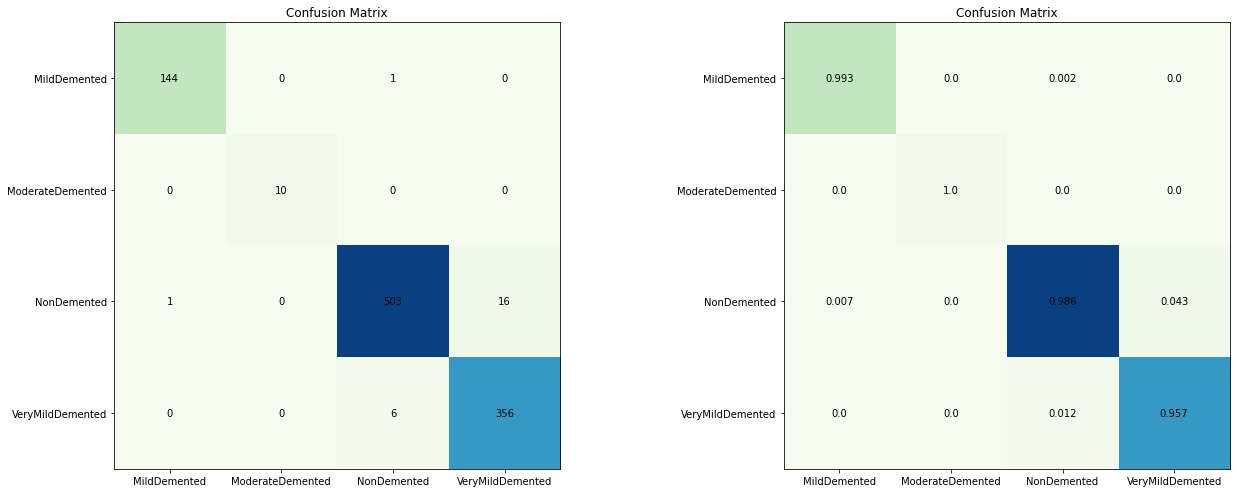

In [20]:
matrix = testModel(modelToTest, testData, labels)
matrix